# Homework 3 (Tutorial 7)

##MA course in Artificial Intelligence 2022/2023

insert your "Name Surname"

In [1]:
!rm -r AI2022MA/
!git clone https://github.com/UmbertoJr/AI2022MA.git &> /dev/null

rm: cannot remove 'AI2022MA/': No such file or directory


name: eil76
nPoints: 76
best_sol: 538.0


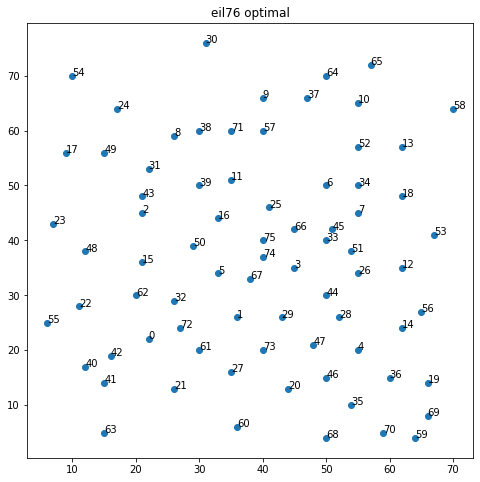

In [2]:
# Imports

from AI2022MA.IO_manager.io_tsp import TSP_Instance_Creator
# if you are running from your local remove the prefix AI2020 (comment the previous line and uncomment the following line)
# from IO_manager.io_tsp import TSP_Instance_Creator

ic = TSP_Instance_Creator("standard", 'eil76.tsp')
ic.print_info()
ic.plot_data()

name: ch130
nPoints: 130
best_sol: 6110.0


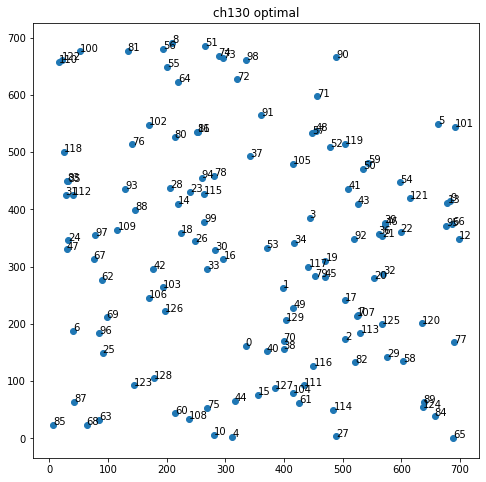

In [3]:
ic = TSP_Instance_Creator("standard", 'ch130.tsp')
ic.print_info()
ic.plot_data()

name: d198
nPoints: 198
best_sol: 15780.0


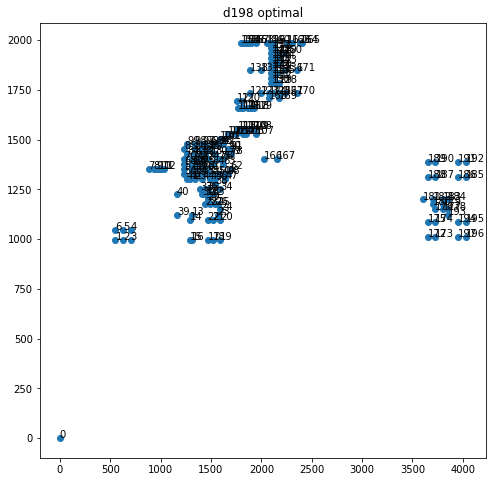

In [4]:
ic = TSP_Instance_Creator("standard", 'd198.tsp')
ic.print_info()
ic.plot_data()

name: myTSP_dim10
nPoints: 10
best_sol: 2732.0


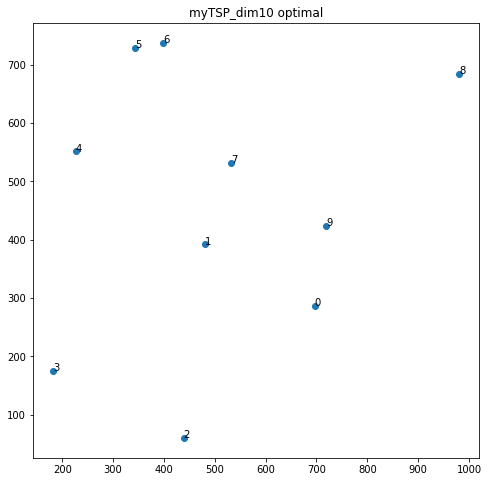

In [5]:
ic = TSP_Instance_Creator("standard", 'myTSP_dim10.tsp')
ic.print_info()
ic.plot_data()

In [6]:
from numpy.core.fromnumeric import nonzero
import numpy as np
import random
import operator
from AI2022MA.solvers.local_search import twoOpt
from AI2022MA.solvers.constructive_algorithms import nn
from AI2022MA.solvers.two_opt_with_candidate import twoOpt_with_cl
import time

# nn takes as input the distance matrix and returns 
# the tour and the length constructed with nearest neighbor, i.e.   tour, len_t = nn(dist_mat)

# twoOpt takes as input the solution, the actual_len and the distance matrix 
# and returns the tour and the length created with 2-opt, i.e.     tour, lent_t = twoOpt(solution, actual_len, dist_mat)

class ACS:
  m = 10
  beta = 2
  alpha = rho = 0.1
  cl = 15 
  q0 = 0.5
  two_opt_bool = True

  @staticmethod
  def take_candidates(j, dist_mat):
    return list(np.argsort(dist_mat[j])[1:ACS.cl+1])

  def __init__(self, instance, two_opt_bool=True, q0_value = 0.98):
    ACS.two_opt_bool = two_opt_bool
    ACS.q0 = q0_value
    self.n = instance.nPoints
    #just to be sure to have a meaningfull number of acl
    if ACS.cl > self.n:
      ACS.cl = int(self.n/2)-1
    
    self.counter = 0
    self.counter_best = -1
    self.best_tours_lenght = np.array([])
    self.dist_mat = instance.dist_matrix
    self.best_lenght = 0
    self.best_ant = -1
    _, self.L_nn = nn(instance.dist_matrix, starting_node=np.random.choice(self.n))
    self.tau0 = 1./(float(self.n) * self.L_nn)
    #self.pheromone = {r: [self.tau0]*ACS.cl for r in range(self.n)} why only for candidate lists?
    #initialize pheromone for every edge
    self.pheromone = {r: np.array([self.tau0 if s != r else 0 for s in range(self.n)]) for r in range(self.n)}
    self.candidate_list = {r: ACS.take_candidates(r, instance.dist_matrix) for r in range(self.n)}
    #self.eta = {r: [1/self.dist_mat[r, s] for s in ACS.take_candidates(r, instance.dist_matrix)] for r in range(self.n)} why only for candidate lists?
    #initialize eta for each edge
    self.eta = {r: np.array([1/self.dist_mat[r, s] if s != r else 0 for s in range(self.n)]) for r in range(self.n)}
    #starting positions of the ants
    self.position = {i: np.random.randint(0,self.n) for i in range(ACS.m)}  # position collector for the Ants, TO BE UPDATED during the steps 
    #visited cities
    self.tour = {i: np.array([self.position[i]]) for i in range(ACS.m)}  # tour collector for the Ants
    #cities still to be visited by the ants
    self.Jset = {i: np.array([h for h in range(self.n)][0:self.position[i]] + [h for h in range(self.n)][self.position[i]+1:self.n]) for i in range(ACS.m)}  

    self.absolute_best_tour = []
    self.absolute_best_ant = -1
    self.absolute_best_lenght = np.inf
  
  
  def restart_variables(self):
    #each time we complete the iteration, all the cities must be freed and the ants restart from a new random position
    self.position = {i: np.random.randint(0,self.n) for i in range(ACS.m)}  # position collector for the Ants, TO BE UPDATED during the steps 
    self.tour = {i: np.array([self.position[i]]) for i in range(ACS.m)}  # tour collector for the Ants
    self.Jset = {i: np.array([h for h in range(self.n)][0:self.position[i]] + [h for h in range(self.n)][self.position[i]+1:self.n]) for i in range(ACS.m)}  


  def pseudo_random_proportional_rule(self, ant_index):
    #sampling q from a normal distribution
    q = np.random.uniform(low=0.0, high=1.0, size=None)
    #check if the current city has some candidate cities, if not consider all the other unvisited cities
    available = list(set(self.Jset[ant_index]) & set(self.candidate_list[self.position[ant_index]]))
    if len(available) < 1:
      available = self.Jset[ant_index]
    #if q is smaller or equal than q0 we exploit according to the formula 
    if q < ACS.q0: 
      desiderability = {free_city: self.pheromone[self.position[ant_index]][free_city] *
                                  self.eta[self.position[ant_index]][free_city]**ACS.beta
                                  for free_city in available} #iterate through available cities
      next_city = max(desiderability.items(), key=operator.itemgetter(1))[0]
    #otherwise we explore using the same formula as the state transition of the ant system
    else: 
      tot_sum = sum([a * b**ACS.beta for a,b in zip(self.pheromone[self.position[ant_index]] ,self.eta[self.position[ant_index]])])
      probabilities = np.array([(self.pheromone[self.position[ant_index]][free_city]*
                        self.eta[self.position[ant_index]][free_city]**ACS.beta
                      /tot_sum)
                      for free_city in available])

      next_city = random.choices(available, weights=probabilities, k=1)[0]
    #updating the current position, the tour and the not yet visited cities
    self.position[ant_index] = next_city
    self.tour[ant_index] = np.append(self.tour[ant_index], next_city)
    self.Jset[ant_index] = np.delete(self.Jset[ant_index], np.argwhere(self.Jset[ant_index] == next_city))

  
  def local_updating(self, ant_index):
      #update the pheromone on the edge between city ith and ith-1, so the last two of the tour
      rk = self.tour[ant_index][-2]
      sk = self.tour[ant_index][-1]
      self.pheromone[rk][sk] = (1-ACS.rho)*self.pheromone[rk][sk] + ACS.rho*self.tau0
  

  def best_tour_evaluation(self):
    #i compute the lenght of all the tours and then take the minimum one as the best of the iteration
    #note that i have added the first city also as the last element of the tour, so i can do it with just a loop
    tours_lenght = []
    for k in range(ACS.m):
      tours_lenght.append(sum([self.dist_mat[rk][sk] for rk,sk
                               in zip(self.tour[k][0:len(self.tour[k])-1],
                                      self.tour[k][1:len(self.tour[k])])]))

    tours_lenght = np.array(tours_lenght)
    self.best_lenght = np.min(tours_lenght)
    self.best_ant = np.argmin(tours_lenght)
    self.best_tours_lenght = np.append(self.best_tours_lenght, self.best_lenght)

    #if the current best is smaller than the absloute best, i update it
    if self.best_lenght < self.absolute_best_lenght:
      self.absolute_best_lenght = self.best_lenght
      self.absolute_best_ant = self.best_ant
      self.absolute_best_tour = self.tour[self.best_ant]
      self.counter_best = self.counter
      #print(self.absolute_best_lenght)
  

  def global_update(self):
    #global updating of all the edge according to the gloabl update formula
    #if an edge is not in the current best tour, the pheromone decrese, if it is the pheromone is incraesed
    for city in range(1,len(self.tour[self.best_ant])):
      rk = self.tour[self.best_ant][city-1]
      for sk in range(self.n):
          if sk != rk:
            #the city sk is in the best tour
            if sk == self.tour[self.best_ant][city]:
              theta = ACS.alpha*(1/self.best_lenght)
            #the city sk is not in the best tour
            else:
              theta = 0  
            self.pheromone[rk][sk] = (1-ACS.alpha)*self.pheromone[rk][sk] + theta


  def solve(self, time_to_solve=180):
    starting_time = time.time()
    while time_to_solve > int(time.time()-starting_time):
      self.counter += 1
      #each new iteration i restart the ants positions, the visited cities and the tours
      self.restart_variables()
      #building the tour
      for i in range(1, self.n+1):
        if i < self.n: # choose next city
          for k in range(ACS.m):
            self.pseudo_random_proportional_rule(k)
        else: #ants go back to starting city (tour finished)
          for k in range(ACS.m):
            self.position[k] = self.tour[k][0]
            self.tour[k] = np.append(self.tour[k], self.tour[k][0])
        #local updating
        for k in range(ACS.m):
          self.local_updating(k)

      #global updating
      self.best_tour_evaluation()
      #two_opt enhancement
      if ACS.two_opt_bool:
        tt, tl = twoOpt_with_cl(self.tour[self.best_ant][0:len(self.tour[self.best_ant])-1], self.best_lenght, self.dist_mat, self.candidate_list)
        if tl < self.best_lenght:
          self.tour[self.best_ant], self.best_lenght = tt, tl
          self.tour[self.best_ant] = np.append(self.tour[self.best_ant], self.tour[self.best_ant][0])
          self.best_tours_lenght[-1] = self.best_lenght

          if self.best_lenght < self.absolute_best_lenght:
            self.absolute_best_lenght = self.best_lenght
            self.absolute_best_ant = self.best_ant
            self.absolute_best_tour = self.tour[self.best_ant]
            self.counter_best = self.counter
            
      #gloab update phase
      self.global_update()
      



In [ ]:
#for asdfg in range(1000):
acs = ACS(ic)
#print('cities: ', acs.n, ' cl: ', acs.cl)
#print('tau0 =', acs.pheromone[0][0:5])
#print('eta =', acs.eta[0][0:5])

#for j in acs.candidate_list.keys():
#  print()
#  print("node          :", j)
#  print("candidate list:", acs.candidate_list[j][:3])
#  print("eta values    :", acs.eta[j][:3])
#  print("pheromone     :", acs.pheromone[j][:3])
#  if j>2:
#    break

acs.solve(5)
#for t in acs.tour.items():
  #print(t)
  #print('-------------------------------------')
print(acs.absolute_best_lenght)
  

2732.0


# Running ACS following the paper and the homwork instruction

In [ ]:
seeds = [1,2,3]
problem_instances = ['eil76.tsp', 'ch130.tsp', 'd198.tsp']

q0_stats = {
    0: [],
    1: [],
    2: [],
}

for problem_instance in problem_instances:
  for random_seed in seeds:

    ic = TSP_Instance_Creator("standard", problem_instance, seed=random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)

    q0s = [0.5, 0.98, 1-13/ic.nPoints]

    for qindx in range(3):

      acs = ACS(ic, q0_value=q0s[qindx])
      acs.solve(time_to_solve=180)

      q0_stats[qindx].append(acs.absolute_best_lenght)

print(sum(q0_stats[0])/len(q0_stats[0]))
print(sum(q0_stats[1])/len(q0_stats[1]))
print(sum(q0_stats[2])/len(q0_stats[2]))
print('best_q0:', q0s[np.argmin(np.array([sum(q0_stats[0])/len(q0_stats[0]), sum(q0_stats[1])/len(q0_stats[1]), sum(q0_stats[2])/len(q0_stats[2])]))])

8015.888888888889
7742.777777777777
7722.222222222223
best_q0: 0.9343434343434344


In [ ]:
import pandas as pd

#using the best q0 value found, indeed 1-13/n
#even though the difference with keeping always 0.98 is really small (as claimed in the paper)
seeds = [10, 20, 30, 40, 50]
two_opt_bool = [True, False]
problem_instances = ['eil76.tsp', 'ch130.tsp', 'd198.tsp']

stats_name = [
    'problem instance', 'seed','two opt', 'real optimum' , 'best tour lenght',
    'tours to optimal sol', 'relative error','best tours lenght'
]

stats = []

for two_opt in two_opt_bool:
  for problem_instance in problem_instances:
    for random_seed in seeds:

      ic = TSP_Instance_Creator("standard", problem_instance, seed=random_seed)
      np.random.seed(random_seed)
      random.seed(random_seed)

      acs = ACS(ic, two_opt, 1-13/ic.nPoints)
      acs.solve(time_to_solve=180)

      stats.append([
          problem_instance,
          random_seed,
          two_opt,
          ic.best_sol,
          acs.absolute_best_lenght,
          acs.counter_best,
          (acs.absolute_best_lenght/ic.best_sol-1)*100,
          (acs.best_tours_lenght/ic.best_sol-1)*100
      ])


df = pd.DataFrame(stats, columns=stats_name)
      

In [ ]:
df = pd.DataFrame(stats, columns=stats_name)
df['best tour lenght'] = df['best tour lenght'].astype(int) 

In [ ]:
df[['problem instance',	'seed',	'two opt',	'real optimum',	'best tour lenght',	'tours to optimal sol',	'relative error']]

,problem instance,seed,two opt,real optimum,best tour lenght,tours to optimal sol,relative error
0,eil76.tsp,10,True,538.0,544.0,1651,1.115242
1,eil76.tsp,20,True,538.0,548.0,182,1.858736
2,eil76.tsp,30,True,538.0,546.0,455,1.486989
3,eil76.tsp,40,True,538.0,548.0,292,1.858736
4,eil76.tsp,50,True,538.0,543.0,1294,0.929368
5,ch130.tsp,10,True,6110.0,6446.0,925,5.499182
6,ch130.tsp,20,True,6110.0,6229.0,520,1.947627
7,ch130.tsp,30,True,6110.0,6218.0,821,1.767594
8,ch130.tsp,40,True,6110.0,6251.0,205,2.307692
9,ch130.tsp,50,True,6110.0,6215.0,333,1.718494


In [ ]:
df[['problem instance',	'two opt',	'real optimum',	'best tour lenght',	'tours to optimal sol',	'relative error']].groupby('two opt').mean()

,real optimum,best tour lenght,tours to optimal sol,relative error
two opt,,,,
False,7476.0,8126.666667,299.666667,7.911588
True,7476.0,7717.133333,536.600000,2.535813


In [ ]:
df[['problem instance',	'two opt',	'real optimum',	'best tour lenght',	'tours to optimal sol',	'relative error']].groupby('problem instance').mean()

,two opt,real optimum,best tour lenght,tours to optimal sol,relative error
problem instance,,,,,
ch130.tsp,0.5,6110.0,6480.0,374.8,6.055646
d198.tsp,0.5,15780.0,16728.3,292.6,6.009506
eil76.tsp,0.5,538.0,557.4,587.0,3.605948


In [ ]:
df[['problem instance', 'two opt', 'real optimum', 'best tour lenght', 'tours to optimal sol', 'relative error']].groupby(['problem instance','two opt']).mean()

real optimum  best tour lenght  \
problem instance two opt                                   
ch130.tsp        False          6110.0            6688.2   
                 True           6110.0            6271.8   
d198.tsp         False         15780.0           17122.8   
                 True          15780.0           16333.8   
eil76.tsp        False           538.0             569.0   
                 True            538.0             545.8   

                          tours to optimal sol  relative error  
problem instance two opt                                        
ch130.tsp        False                   188.8        9.463175  
                 True                    560.8        2.648118  
d198.tsp         False                   311.0        8.509506  
                 True                    274.2        3.509506  
eil76.tsp        False                   399.2        5.762082  
                 True                    774.8        1.449814

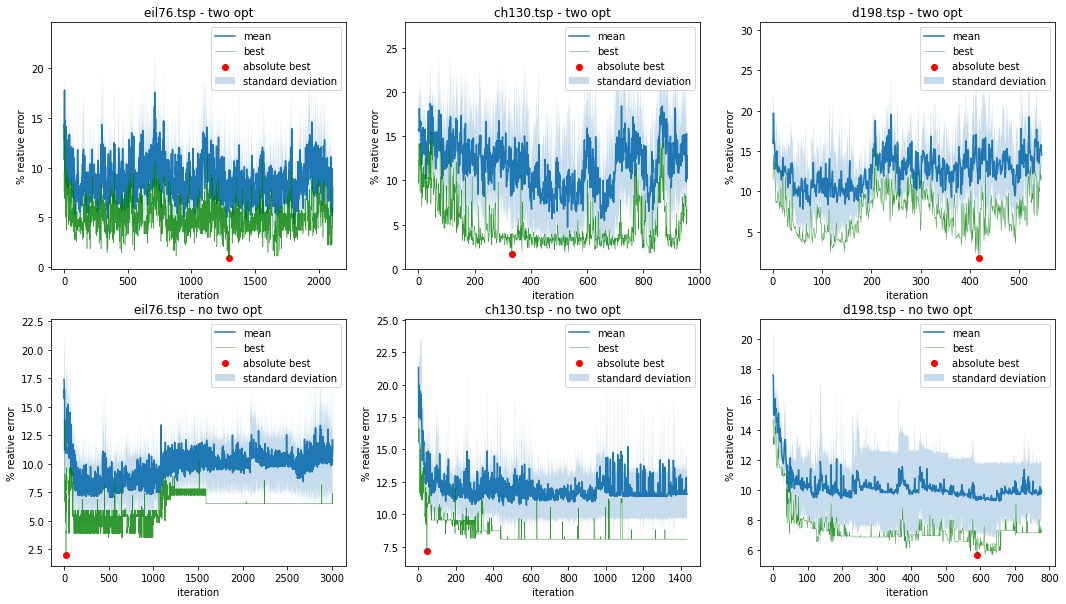

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 3, figsize=(18,10))

p1two_opt = df['best tours lenght'][0:5]
finish = np.min([len(p1two_opt[0]),len(p1two_opt[1]),len(p1two_opt[2]),len(p1two_opt[3]),len(p1two_opt[4])], axis=0)
mean = np.mean([
    p1two_opt[0][0:finish],
    p1two_opt[1][0:finish],
    p1two_opt[2][0:finish],
    p1two_opt[3][0:finish],
    p1two_opt[4][0:finish],
], axis=0)

min = np.min([
    p1two_opt[0][0:finish],
    p1two_opt[1][0:finish],
    p1two_opt[2][0:finish],
    p1two_opt[3][0:finish],
    p1two_opt[4][0:finish],
], axis=0)

std = np.std([
    p1two_opt[0][0:finish],
    p1two_opt[1][0:finish],
    p1two_opt[2][0:finish],
    p1two_opt[3][0:finish],
    p1two_opt[4][0:finish],
], axis=0)

axs[0, 0].set_title('eil76.tsp - two opt')
axs[0, 0].plot([i for i in range(finish)], mean, label='mean')
axs[0, 0].plot([i for i in range(finish)], min, color='green', alpha=0.8, linewidth=0.5, label='best')
axs[0, 0].scatter(np.argmin(min), np.min(min), color='red', label='absolute best')
axs[0, 0].fill_between([i for i in range(finish)], mean+std, mean-std, alpha=0.25, label='standard deviation')
axs[0, 0].legend()
axs[0, 0].set_ylabel('% reative error')
axs[0, 0].set_xlabel('iteration')

p2two_opt = df['best tours lenght'][5:10]
finish = np.min([len(p2two_opt[5]),len(p2two_opt[6]),len(p2two_opt[7]),len(p2two_opt[8]),len(p2two_opt[9])], axis=0)
mean = np.mean([
    p2two_opt[5][0:finish],
    p2two_opt[6][0:finish],
    p2two_opt[7][0:finish],
    p2two_opt[8][0:finish],
    p2two_opt[9][0:finish],
], axis=0)

min = np.min([
    p2two_opt[5][0:finish],
    p2two_opt[6][0:finish],
    p2two_opt[7][0:finish],
    p2two_opt[8][0:finish],
    p2two_opt[9][0:finish],
], axis=0)

std = np.std([
    p2two_opt[5][0:finish],
    p2two_opt[6][0:finish],
    p2two_opt[7][0:finish],
    p2two_opt[8][0:finish],
    p2two_opt[9][0:finish],
], axis=0)

axs[0, 1].set_title('ch130.tsp - two opt')
axs[0, 1].plot([i for i in range(finish)], mean, label='mean')
axs[0, 1].plot([i for i in range(finish)], min, color='green', alpha=0.8, linewidth=0.5, label='best')
axs[0, 1].scatter(np.argmin(min), np.min(min), color='red', label='absolute best')
axs[0, 1].fill_between([i for i in range(finish)], mean+std, mean-std, alpha=0.25, label='standard deviation')
axs[0, 1].legend()
axs[0, 1].set_ylabel('% reative error')
axs[0, 1].set_xlabel('iteration')

p3two_opt = df['best tours lenght'][10:15]
finish = np.min([len(p3two_opt[10]),len(p3two_opt[11]),len(p3two_opt[12]),len(p3two_opt[13]),len(p3two_opt[14])], axis=0)
mean = np.mean([
    p3two_opt[10][0:finish],
    p3two_opt[11][0:finish],
    p3two_opt[12][0:finish],
    p3two_opt[13][0:finish],
    p3two_opt[14][0:finish],
], axis=0)

min = np.min([
    p3two_opt[10][0:finish],
    p3two_opt[11][0:finish],
    p3two_opt[12][0:finish],
    p3two_opt[13][0:finish],
    p3two_opt[14][0:finish],
], axis=0)

std = np.std([
    p3two_opt[10][0:finish],
    p3two_opt[11][0:finish],
    p3two_opt[12][0:finish],
    p3two_opt[13][0:finish],
    p3two_opt[14][0:finish],
], axis=0)

axs[0, 2].set_title('d198.tsp - two opt')
axs[0, 2].plot([i for i in range(finish)], mean, label='mean')
axs[0, 2].plot([i for i in range(finish)], min, color='green', alpha=0.8, linewidth=0.5, label='best')
axs[0, 2].scatter(np.argmin(min), np.min(min), color='red', label='absolute best')
axs[0, 2].fill_between([i for i in range(finish)], mean+std, mean-std, alpha=0.25, label='standard deviation')
axs[0, 2].legend()
axs[0, 2].set_ylabel('% reative error')
axs[0, 2].set_xlabel('iteration')

p1Notwo_opt = df['best tours lenght'][15:20]
finish = np.min([len(p1Notwo_opt[15]),len(p1Notwo_opt[16]),len(p1Notwo_opt[17]),len(p1Notwo_opt[18]),len(p1Notwo_opt[19])], axis=0)
mean = np.mean([
    p1Notwo_opt[15][0:finish],
    p1Notwo_opt[16][0:finish],
    p1Notwo_opt[17][0:finish],
    p1Notwo_opt[18][0:finish],
    p1Notwo_opt[19][0:finish],
], axis=0)

min = np.min([
    p1Notwo_opt[15][0:finish],
    p1Notwo_opt[16][0:finish],
    p1Notwo_opt[17][0:finish],
    p1Notwo_opt[18][0:finish],
    p1Notwo_opt[19][0:finish],
], axis=0)

std = np.std([
    p1Notwo_opt[15][0:finish],
    p1Notwo_opt[16][0:finish],
    p1Notwo_opt[17][0:finish],
    p1Notwo_opt[18][0:finish],
    p1Notwo_opt[19][0:finish],
], axis=0)

axs[1, 0].set_title('eil76.tsp - no two opt')
axs[1, 0].plot([i for i in range(finish)], mean, label='mean')
axs[1, 0].plot([i for i in range(finish)], min, color='green', alpha=0.8, linewidth=0.5, label='best')
axs[1, 0].scatter(np.argmin(min), np.min(min), color='red', label='absolute best')
axs[1, 0].fill_between([i for i in range(finish)], mean+std, mean-std, alpha=0.25, label='standard deviation')
axs[1, 0].legend()
axs[1, 0].set_ylabel('% reative error')
axs[1, 0].set_xlabel('iteration')


p2Notwo_opt = df['best tours lenght'][20:25]
finish = np.min([len(p2Notwo_opt[20]),len(p2Notwo_opt[21]),len(p2Notwo_opt[22]),len(p2Notwo_opt[23]),len(p2Notwo_opt[24])], axis=0)
mean = np.mean([
    p2Notwo_opt[20][0:finish],
    p2Notwo_opt[21][0:finish],
    p2Notwo_opt[22][0:finish],
    p2Notwo_opt[23][0:finish],
    p2Notwo_opt[24][0:finish],
], axis=0)

min = np.min([
    p2Notwo_opt[20][0:finish],
    p2Notwo_opt[21][0:finish],
    p2Notwo_opt[22][0:finish],
    p2Notwo_opt[23][0:finish],
    p2Notwo_opt[24][0:finish],
], axis=0)

std = np.std([
    p2Notwo_opt[20][0:finish],
    p2Notwo_opt[21][0:finish],
    p2Notwo_opt[22][0:finish],
    p2Notwo_opt[23][0:finish],
    p2Notwo_opt[24][0:finish],
], axis=0)

axs[1, 1].set_title('ch130.tsp - no two opt')
axs[1, 1].plot([i for i in range(finish)], mean, label='mean')
axs[1, 1].plot([i for i in range(finish)], min, color='green', alpha=0.8, linewidth=0.5, label='best')
axs[1, 1].scatter(np.argmin(min), np.min(min), color='red', label='absolute best')
axs[1, 1].fill_between([i for i in range(finish)], mean+std, mean-std, alpha=0.25, label='standard deviation')
axs[1, 1].legend()
axs[1, 1].set_ylabel('% reative error')
axs[1, 1].set_xlabel('iteration')

p3Notwo_opt = df['best tours lenght'][25:30]
finish = np.min([len(p3Notwo_opt[25]),len(p3Notwo_opt[26]),len(p3Notwo_opt[27]),len(p3Notwo_opt[28]),len(p3Notwo_opt[29])], axis=0)
mean = np.mean([
    p3Notwo_opt[25][0:finish],
    p3Notwo_opt[26][0:finish],
    p3Notwo_opt[27][0:finish],
    p3Notwo_opt[28][0:finish],
    p3Notwo_opt[29][0:finish],
], axis=0)

std = np.std([
    p3Notwo_opt[25][0:finish],
    p3Notwo_opt[26][0:finish],
    p3Notwo_opt[27][0:finish],
    p3Notwo_opt[28][0:finish],
    p3Notwo_opt[29][0:finish],
], axis=0)

min = np.min([
    p3Notwo_opt[25][0:finish],
    p3Notwo_opt[26][0:finish],
    p3Notwo_opt[27][0:finish],
    p3Notwo_opt[28][0:finish],
    p3Notwo_opt[29][0:finish],
], axis=0)

axs[1, 2].set_title('d198.tsp - no two opt')
axs[1, 2].plot([i for i in range(finish)], mean, label='mean')
axs[1, 2].plot([i for i in range(finish)], min, color='green', alpha=0.8, linewidth=0.5, label='best')
axs[1, 2].scatter(np.argmin(min), np.min(min), color='red', label='absolute best')
axs[1, 2].fill_between([i for i in range(finish)], mean+std, mean-std, alpha=0.25, label='standard deviation')
axs[1, 2].legend()
axs[1, 2].set_ylabel('% reative error')
axs[1, 2].set_xlabel('iteration')

plt.show()